In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima, ARIMA, model_selection


In [3]:
df = pd.read_csv("../CSVs/daily_revenue.csv", index_col="date", dayfirst=True, parse_dates=True)
df.head()

,revenue,discount_rate,coupon_rate
date,,,
2018-01-01,"6,270,839",34.27%,1.09%
2018-01-02,"8,922,076",30.87%,1.08%
2018-01-03,"8,446,101",28.11%,1.01%
2018-01-04,"7,785,798",27.32%,0.96%
2018-01-05,"6,375,303",25.70%,0.90%


In [4]:
df['revenue'] = df['revenue'].str.replace(',', '').astype(float)
df = df.asfreq('D')
df.index

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-11-21', '2022-11-22', '2022-11-23', '2022-11-24',
               '2022-11-25', '2022-11-26', '2022-11-27', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='date', length=1795, freq='D')

In [5]:
#Splitting the data into training and testing sets
periods = 30
train, test = df.iloc[:-periods], df.iloc[-periods:]

test

,revenue,discount_rate,coupon_rate
date,,,
2022-11-01,16703680.0,23.85%,1.50%
2022-11-02,15827022.0,20.76%,0.94%
2022-11-03,16154319.0,21.85%,0.92%
2022-11-04,14707212.0,20.17%,0.88%
2022-11-05,14877530.0,17.85%,0.41%
2022-11-06,18835528.0,16.40%,0.31%
2022-11-07,16094516.0,17.11%,0.30%
2022-11-08,15589508.0,16.64%,0.29%
2022-11-09,16608320.0,18.72%,0.74%


In [6]:
# Using pmdarima to find the best SARIMA model and best parameters
model = auto_arima(train['revenue'], m=7)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(3, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -28762.051
Date:                           Sat, 21 Jun 2025   AIC                          57546.103
Time:                                   17:50:01   BIC                          57606.331
Sample:                               01-01-2018   HQIC                         57568.358
                                    - 10-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.007e+04   4682.784      2.150      0.032     890.230    1.92e+04
ar.L1         -0.3476      0.072     -4.797      0.000      -0.490      -0.206
ar.L2          0.1856      0.032      5.722      0.000       0.122       0.249
ar.L3          0.1034      0.016      6.523      0.000       0.072       0.135
ma.L1         -0.1958      0.074     -2.656      0.008      -0.340      -0.051
ma.L2         -0.5684      0.060     -9.401      0.000      -0.687      -0.450
ar.S.L7        0.0805      0.181      0.445      0.656      -0.274       0.435
ar.S.L14       0.8713      0.172      5.071      0.000       0.535       1.208
ma.S.L7       -0.0035      0.176     -0.020      0.984      -0.349       0.342
ma.S.L14      -0.8322      0.157     -5.310      0.000      -1.139      -0.525
sigma2      9.294e+12      0.000   8.85e+16      0.000    9.29e+12    9.29e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            848650.56
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             5.24
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.19e+31. Standard errors may be unstable.
"""

In [7]:
# Prediciton using the best ARIMA model
predictions = model.predict(n_periods=periods)
predictions

2022-11-01    1.513412e+07
2022-11-02    1.504534e+07
2022-11-03    1.464458e+07
2022-11-04    1.382188e+07
2022-11-05    1.398002e+07
2022-11-06    1.697854e+07
2022-11-07    1.583307e+07
2022-11-08    1.605210e+07
2022-11-09    1.575797e+07
2022-11-10    1.523585e+07
2022-11-11    1.428028e+07
2022-11-12    1.448986e+07
2022-11-13    1.761290e+07
2022-11-14    1.658423e+07
2022-11-15    1.682759e+07
2022-11-16    1.635487e+07
2022-11-17    1.582120e+07
2022-11-18    1.482106e+07
2022-11-19    1.499263e+07
2022-11-20    1.780768e+07
2022-11-21    1.673570e+07
2022-11-22    1.694580e+07
2022-11-23    1.665824e+07
2022-11-24    1.616895e+07
2022-11-25    1.526419e+07
2022-11-26    1.547008e+07
2022-11-27    1.842689e+07
2022-11-28    1.745384e+07
2022-11-29    1.769224e+07
2022-11-30    1.726672e+07
Freq: D, dtype: float64

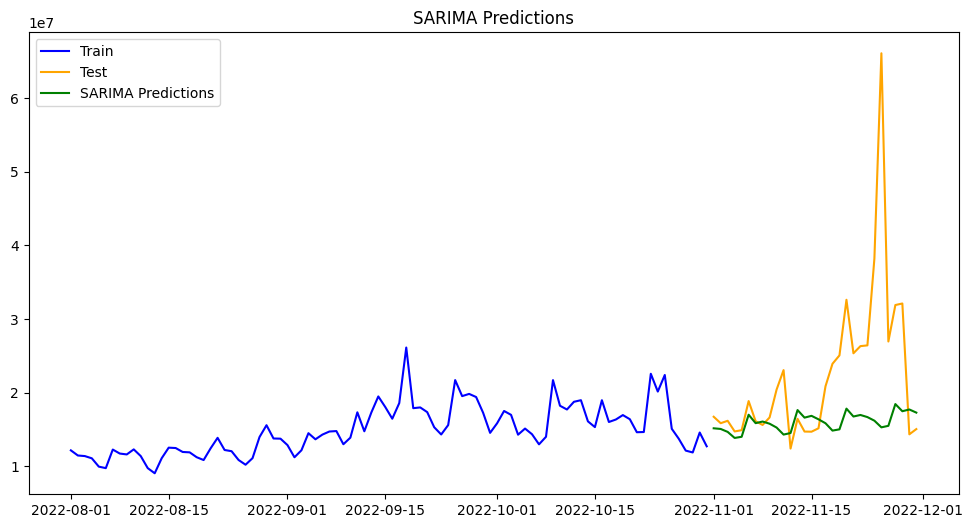

Mean Absolute Error (MAE) for SARIMA: 7210545.18
Root Mean Squared Error (RMSE) for SARIMA: 12152388.09
Mean Absolute Percentage Error (MAPE) for SARIMA: 24.54%


In [8]:
def assess_model(train, test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label='Train', color='blue')
    plt.plot(test, label='Test', color='orange')
    plt.plot(predictions, label=f'{model_name} Predictions', color='green')
    plt.title(f'{model_name} Predictions')
    plt.legend()
    plt.show()

    mae = mean_absolute_error(test, predictions)
    print(f'Mean Absolute Error (MAE) for {model_name}: {mae:.2f}')
    rmse = mean_squared_error(test, predictions)  
    rmse = rmse ** 0.5
    print(f'Root Mean Squared Error (RMSE) for {model_name}: {rmse:.2f}')
    mape = mean_absolute_percentage_error(test, predictions)        
    print(f'Mean Absolute Percentage Error (MAPE) for {model_name}: {mape:.2%}') 


assess_model(train['revenue']['2022-08':], test['revenue']['2022-08':], predictions, 'SARIMA')